On commence par importer les bibliothèques nécessaires. Attention : NE PAS EFFACER !

In [1]:
from pylab import *    # charge toutes les bibliothèques scientifiques
from scipy.optimize import curve_fit    # permet de modéliser selon un modèle personnalisé
from lmfit import minimize,Parameters,Parameter,report_fit
from lmfit.models import ExpressionModel

from time import *    # pour les mesures de temps
uc = []

def myCallback(data):
    uc.append(data)

# Paramètres de graphique
%matplotlib ipympl
rcParams['figure.figsize'] = [16, 8]    # pour une fenetre graphique adaptée
rcParams['font.size'] = 15    # pour un texte plus grand
rcParams['lines.markersize'] = 15    # pour des symboles plus grands
rcParams['lines.markeredgewidth'] = 2    # pour des symboles plus larges

Conditions expérimentales :

In [2]:
charge = 0    # mettre 1 pour la charge du condensateur, et 0 pour sa décharge
duree =  0.2    # Entrer la durée d'acquisition désirée en s

On se connecte à Arduino :

In [3]:
# On initialise la carte Arduino avec le protocole firmata2
import pyfirmata2
carte = pyfirmata2.Arduino('/dev/ttyACM0')
carte.samplingOn(1)    # durée entre 2 mesures successives en ms. Le minimum est 1 ms.
print("Connexion établie")
EA0 = carte.get_pin('a:0:i')    # (a/d : numéro de voie : i/o/p)
SD13 = carte.get_pin('d:13:o')
SD13.write(1 - charge)    # À remplir avec 0 ou 1 : on met l'alimentation sur 0 V ou 5V selon les conditions initiales
sleep(duree)

Connexion établie


Interaction avec les voies définies précédemment :

In [4]:
SD13.write(charge)    # À remplir avec 0 ou 1 : on met l'alimentation sur 0 V ou 5V selon les conditions initiales
EA0.register_callback(myCallback)
EA0.enable_reporting()
sleep(duree)    # Mettre la durée en s, attente de la décharge complète du condensateur
carte.samplingOff()
carte.exit()
t = arange(0, duree, 1e-3)
uc = array(uc[int(-1 * duree *1000) : ]) * 5.0    # on garde les dernières valeurs du tableau, la tension est de 5,0 v au maximum

Calcul des caractéristiques de la courbe de régression. Attention : NE PAS SUPPRIMER, et ne le modifier que si les paramètres par défaut ne donnent pas de bon résultat :

In [5]:
def Modele(expression, x, y):
    
    modele = ExpressionModel(expression)    # si la variable indépendante n'est pas "x", ajouter comme argument independant_vars = ["nom"])

    # Cette partie devine les paramètres et leur attribue une valeur initiale de 1 pour la recherche
    parametres = modele.make_params()
    for i in parametres :
        modele.set_param_hint(i, value = 1)
    parametres = modele.make_params()

    modele.set_param_hint('tau', value = 1, vary = True, min = 0, max = inf)    # À compléter pour changer les valeurs initiales des paramètres. Le dernier argument est expr (string)

    resultat = modele.fit(y, parametres, x = x)    # Entrer ici le nom de la variable en x et en y, pour le calcul final des paramètres

    # On affiche les valeurs trouvées pour les paramètres :
    valeurs = ""
    for key in resultat.params:
        valeurs += f"{key} = {resultat.params[key].value:.3g} ; incertitude : {resultat.params[key].stderr:.2g}\n"
    return(modele, resultat.params, valeurs, expression)

## On commence par arranger les expressions avec "x" comme variable, car lmfit travaille avec x par défaut :
abscisse = "t"
ordonnee = "uc"
if charge == 0 :
    equation = "E * exp(-1 * t / tau)"
else :
    equation = "E * (1 - exp(-1 * t / tau))"
abscisse1 = abscisse
ordonnee1 = ordonnee
equation1 = equation
equation = re.sub(r"\b"+abscisse+r"\b","x", equation)
abscisse = globals()[abscisse]
ordonnee = globals()[ordonnee]

# On calcule maintenant les grandeurs liées au modèle :
xMod = linspace(min(abscisse), max(abscisse), 30)    # Intervalle de valeurs pour le modèle : (début, fin, nombre de points)
modele, parametres, valeurs, expression = Modele(equation, abscisse, ordonnee)    # Expression du modèle, et variables en abscisse et en ordonnée
expression = f"{ordonnee1} = {equation1}"
yMod = modele.eval(parametres, x = xMod)

# Les paramètres sont définis de façon globale, et utilisables dans des calculs :
for key in parametres:
    globals()[key] = parametres[key].value

Tracer de graphique(s) à partir des tableaux précédents :

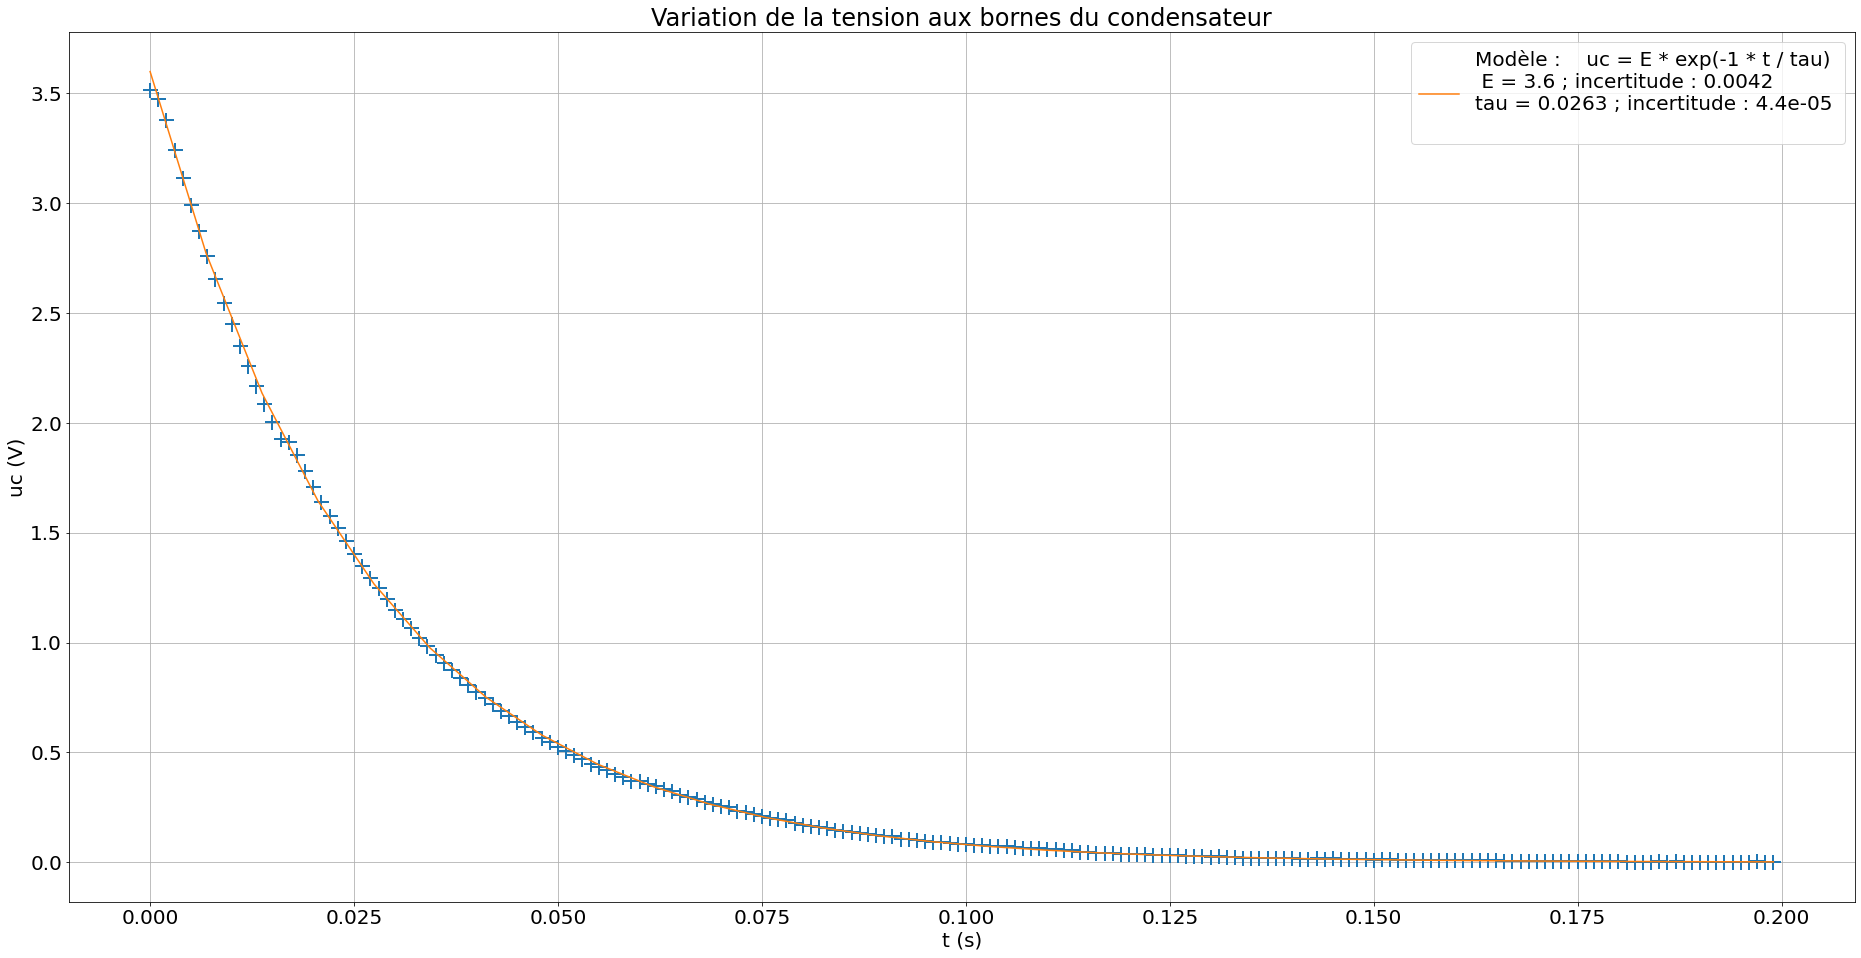

In [6]:
subplot(1, 1, 1)    # lignes, colonnes, numéro du graphique

# Tracé des points expérimentaux :
plot(abscisse, ordonnee, '+', label="")    # abscisse, ordonnée, options : + o . , s points   - -- -. : lignes  b g r y m c k w couleurs ; label est la légende associée à la courbe

# Tracé du modèle :
plot(xMod, yMod, '-', label=f"Modèle :    {expression} \n {valeurs}" )    # trace la courbe du modèle

#axis('equal')    # à décommenter si on veut un repère orthonormé
grid()    # ajoute une grille
legend()    # ajoute la légende au graphique
title("Variation de la tension aux bornes du condensateur")    # mettre le titre désiré entre les guillemets
xlabel("t (s)")    # mettre le nom de l'axe des abscisses entre les guillemets
ylabel("uc (V)");    # mettre le nom de l'axe des ordonnées entre les guillemets. Le point-virgule final évite d'afficher un texte récapitulatif.

Calcul de la valeur de la capacité du condensateur :

In [7]:
R = 220    #Entrer la valeur de la résistance en Ohm
c = tau / R
print(f"La valeur de la capacité du condensateur est {c} F")

La valeur de la capacité du condensateur est 0.00011946924811644115 F
